# Wasserstein distance

## 1-Wasserstein distance:

\begin{equation}
    W_p(\mu, \upsilon) = \left( \underset{\gamma \in \Gamma(\mu, \upsilon)}{\inf} \int \mathrm d(x, y)^p \mathrm d\gamma(x, y) \right)^{1/p}
\end{equation}

where the $d(x, y)$ is a distance metric between two points $x$ and $y$. $\gamma$ is a coupling of the probability measures $\mu$ and $\upsilon$ (a joint probability distribution that belongs to the set of joint distributions $\Gamma(\mu, \upsilon)$ that have marginals $\mu$ and $\upsilon$).

\begin{align*}
    \mathrm d(x, y)^p&: \text{how far is it from } x \text{ to } y \\
    \mathrm d\gamma(x, y)&: \text{how much mass should we move from } x \text{ to } y
\end{align*}

The $\underset{\gamma}{\inf}$ means to find optimal paths to move the mass from one distribution at $x$ to another one at $y$, then the resulted Wasserstein distance between two distributions is the cost (mass $\times$ distance) under the optimal transport paths.

We consider $\mathrm d(x, y) = | x - y |$ and $p = 1$ for simplicity.

## Kantorovich-Rubinstein duality

\begin{equation}
    \sup_f \int f \mathrm d\mu(x) - \int f \mathrm d\upsilon(y)\qquad \text{where } f: \mathbb R^d \rightarrow \mathbb R\,, \text{Lip}(f) \leq 1
\end{equation}

where $\mu$ and $\upsilon$ are probability measures, and $\text{Lip}(f)$ denotes the Lipschitz constant of the function $f$ (can be a neural network). The Lipschitz contraint can be enforced by weight-clipping, gradient penalty and spectral normalization. The neural network is trained to maximize the $\int f \mathrm d\mu(x) - \int f \mathrm d\upsilon(y)$.

## Wasserstein vs f-divergence

f-divergence assumes two distribution has the same support while Wasserstein doesn't. It means that if two distribution is not overlapping with each other, the f-divergence would become meaningless. The definition of f-divergence is:
\begin{equation}
    D_f(p || q) = \int q(x) f\left( \frac{p(x)}{q(x)} \right) \mathrm d x
\end{equation}


KL-divergence is a special case of f-divergence with $f_{\text{KL}}(t) = t \log t$. The definition of KL-divergence:
\begin{equation}
    D_{\text{KL}}(p || q) = \int p(x) \log \frac{p(x)}{q(x)} \mathrm d x
\end{equation}

In [1]:
import torch
import torch.distributions as dist
import matplotlib.pyplot as plt

In [2]:
p = dist.MultivariateNormal(5 * torch.ones(1), 1 * torch.eye(1))
q = dist.MultivariateNormal(5 * torch.ones(1), 1 * torch.eye(1))

num_samples = 512
p_samples = p.sample([num_samples])
q_samples = q.sample([num_samples])

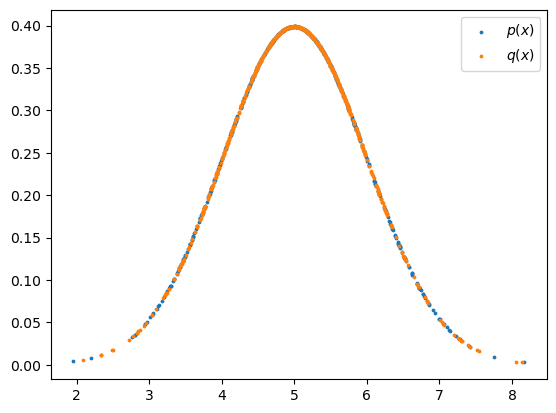

In [3]:
# plt.scatter(p_samples[:, 0], p_samples[:, 1], label=r"$p(x)$", s=3)
# plt.scatter(q_samples[:, 0], q_samples[:, 1], label=r"$q(x)$", s=3)
plt.scatter(p_samples, p.log_prob(p_samples).exp(), label=r"$p(x)$", s=3)
plt.scatter(q_samples, q.log_prob(q_samples).exp(), label=r"$q(x)$", s=3)
plt.legend();

In [4]:
from scipy.stats import wasserstein_distance

wasserstein_distance(p_samples.squeeze(), q_samples.squeeze())

0.07679346203804016

In [5]:
import torch.nn.utils.spectral_norm as sn


class DistanceEstimator(torch.nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.layers = torch.nn.Sequential(
            sn(torch.nn.Linear(input_dim, 128)),
            torch.nn.LeakyReLU(0.2, inplace=True),
            sn(torch.nn.Linear(128, 128)),
            torch.nn.LeakyReLU(0.2, inplace=True),
            sn(torch.nn.Linear(128, 128)),
            torch.nn.LeakyReLU(0.2, inplace=True),
            sn(torch.nn.Linear(128, 1)),
        )

    def forward(self, x):
        logits = self.layers(x)
        return logits


In [6]:
model = DistanceEstimator(input_dim=1)
p_dataloader = torch.utils.data.DataLoader(p_samples, batch_size=64, shuffle=True, pin_memory=True)
q_dataloader = torch.utils.data.DataLoader(q_samples, batch_size=64, shuffle=True, pin_memory=True)

In [7]:
num_epochs = 100
device = 'cpu'

model.train()
# Optimizers
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, betas=(0.5, 0.999))

for epoch in range(num_epochs):
    for i, (data_p, data_q) in enumerate(zip(p_dataloader, q_dataloader), 0):
        optimizer.zero_grad()

        pred_p = model(data_p)
        pred_q = model(data_q)

        loss = pred_q.mean() - pred_p.mean()
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f"loss: {loss.item():>7f}  [{epoch:>5d}/{num_epochs:>5d}]")
        with torch.no_grad():
            distance = model(p_samples).mean() - model(q_samples).mean()
        print(f"predicted distance: {distance}")

loss: -0.002351  [    0/  200]
predicted distance: 0.0024929046630859375
loss: 0.003425  [   10/  200]
predicted distance: 0.0010642409324645996
loss: 0.001239  [   20/  200]
predicted distance: 0.004086971282958984
loss: -0.016895  [   30/  200]
predicted distance: 0.0045435428619384766
loss: 0.003522  [   40/  200]
predicted distance: 0.008538365364074707
loss: 0.032230  [   50/  200]
predicted distance: 0.00923311710357666
loss: -0.038509  [   60/  200]
predicted distance: 0.009526491165161133
loss: -0.049457  [   70/  200]
predicted distance: 0.008326351642608643
loss: 0.033281  [   80/  200]
predicted distance: 0.012121438980102539
loss: -0.040709  [   90/  200]
predicted distance: 0.015356302261352539
loss: -0.010761  [  100/  200]
predicted distance: 0.014115691184997559
loss: 0.071414  [  110/  200]
predicted distance: 0.014897584915161133
loss: 0.032649  [  120/  200]
predicted distance: 0.015703916549682617
loss: -0.012988  [  130/  200]
predicted distance: 0.0144846439361572